In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree


### Preparing the dataset

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-21 08:33:44--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv.2’

housing.csv.2       100%[===================>]   1,36M  2,96MB/s    in 0,5s    

2023-10-21 08:33:45 (2,96 MB/s) - ‘housing.csv.2’ saved [1423529/1423529]



In [3]:
df = pd.read_csv("housing.csv")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
# First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
# Preparation:

# Fill missing values with zeros.
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:

df = df.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
# Apply the log transform to median_house_value.
df.median_house_value = df.median_house_value.apply(np.log1p)

In [8]:
target = df["median_house_value"]
df_train = df.drop(["median_house_value"], axis=1)

In [9]:
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.
X_train_full, X_test, y_train_full, y_test = train_test_split(df_train, target, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1)

In [10]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
dv = DictVectorizer(sparse=True)
X_train_matrix = dv.fit_transform(X_train.to_dict(orient="records"))
X_val_matrix = dv.transform(X_val.to_dict(orient="records"))

### question #1

In [11]:
# Let's train a decision tree regressor to predict the median_house_value variable.

In [13]:
dt = DecisionTreeRegressor(max_depth=1)

In [14]:
dt.fit(X_train_matrix, y_train)

DecisionTreeRegressor(max_depth=1)

In [16]:
feature_names = dv.get_feature_names_out()

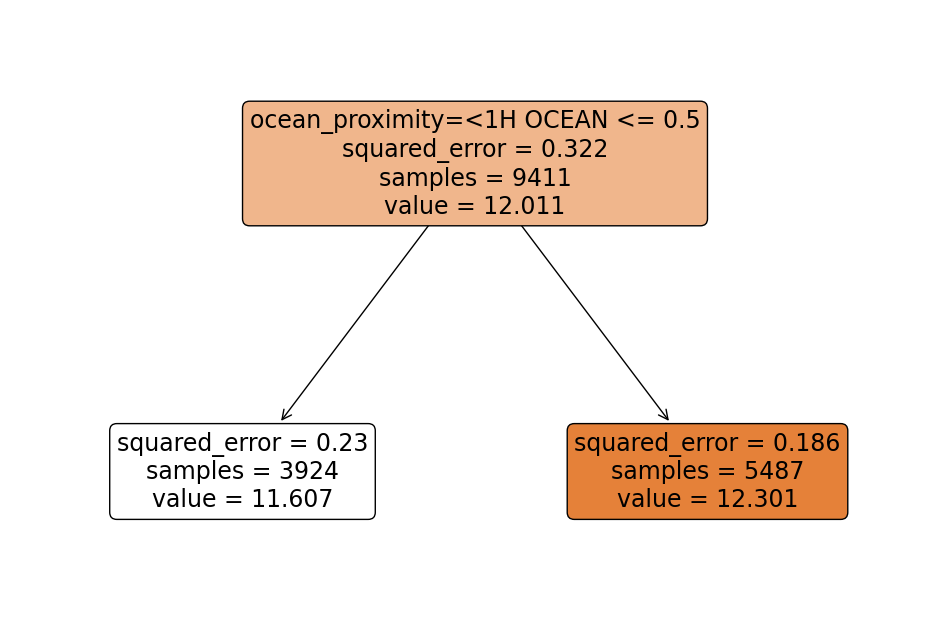

In [17]:
plt.figure(figsize=(12, 8))
plot_tree(dt, filled=True, feature_names=feature_names.tolist(), rounded=True)
plt.show()

In [18]:
# Which feature is used for splitting the data?

`ocean_proximity`

### question #2

In [19]:
# Train a random forest model with these parameters:

In [20]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [21]:
rf.fit(X_train_matrix, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
preds = rf.predict(X_val_matrix)

In [24]:
mean_squared_error(y_val, preds, squared=False)

0.2449529003059715

In [25]:
# What's the RMSE of this model on validation?

`0.2449529003059715`

### question #3

In [26]:
# Now let's experiment with the n_estimators parameter

# Try different values of this parameter from 10 to 200 with step 10.
# Set random_state to 1.
# Evaluate the model on the validation dataset.

for n in range(10, 200, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train_matrix, y_train)
    preds = rf.predict(X_val_matrix)
    print("n_estimators=", n, "rmse=", round(mean_squared_error(y_val, preds, squared=False), 3))

n_estimators= 10 rmse= 0.245
n_estimators= 20 rmse= 0.238
n_estimators= 30 rmse= 0.237
n_estimators= 40 rmse= 0.235
n_estimators= 50 rmse= 0.235
n_estimators= 60 rmse= 0.235
n_estimators= 70 rmse= 0.234
n_estimators= 80 rmse= 0.235
n_estimators= 90 rmse= 0.234
n_estimators= 100 rmse= 0.234
n_estimators= 110 rmse= 0.234
n_estimators= 120 rmse= 0.234
n_estimators= 130 rmse= 0.234
n_estimators= 140 rmse= 0.234
n_estimators= 150 rmse= 0.234
n_estimators= 160 rmse= 0.233
n_estimators= 170 rmse= 0.233
n_estimators= 180 rmse= 0.234
n_estimators= 190 rmse= 0.234


In [27]:
# After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

`n_estimators=50`

### question #4

In [28]:
# Let's select the best max_depth:

#     Try different values of max_depth: [10, 15, 20, 25]
#     For each of these values,
#         try different values of n_estimators from 10 till 200 (with step 10)
#         calculate the mean RMSE
#     Fix the random seed: random_state=1

for n in [10, 15, 20, 25]:
    score = []
    for m in range(10, 200, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=n, random_state=1, n_jobs=-1)
        rf.fit(X_train_matrix, y_train)
        preds = rf.predict(X_val_matrix)
        score.append(round(mean_squared_error(y_val, preds, squared=False), 3))
    print("max_depth=", n, "rmse=", np.mean(score))
    


max_depth= 10 rmse= 0.25100000000000006
max_depth= 15 rmse= 0.24300000000000005
max_depth= 20 rmse= 0.23899999999999996
max_depth= 25 rmse= 0.23700000000000002


In [29]:
# What's the best max_depth, using the mean RMSE?

`max_depth=25, rmse=0.237`

### question #5

In [30]:
# We can extract feature importance information from tree-based models.

# At each step of the decision tree learning algorithm, it finds the best split. 
# When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
# This gain is quite useful in understanding what are the important features for tree-based models.

# In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

# For this homework question, we'll find the most important feature:

#     Train the model with these parameters:
#         n_estimators=10,
#         max_depth=20,
#         random_state=1,
#         n_jobs=-1 (optional)
#     Get the feature importance information from this model
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train_matrix, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
rf.feature_importances_

array([0.01495348, 0.03019435, 0.10189142, 0.0861758 , 0.33566849,
       0.29247297, 0.07380644, 0.02682069, 0.01624481, 0.02177155])

In [32]:
feature_names

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

In [33]:
df_features = pd.DataFrame({
    'feature': feature_names,
    'value': rf.feature_importances_
})

df_sorted = df_features.sort_values(by="value", ascending=False)
df_sorted

,feature,value
4,median_income,0.335668
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101891
3,longitude,0.086176
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030194
7,population,0.026821
9,total_rooms,0.021772
8,total_bedrooms,0.016245
0,households,0.014953


In [34]:
# What's the most important feature (among these 4)?

#     total_rooms
#     median_income
#     total_bedrooms
#     longitude

`median_income`

### question #6

In [40]:
# Now let's train an XGBoost model! For this question, we'll tune the eta parameter:
# Install XGBoost

In [41]:
# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train_matrix, label=y_train)
dval = xgb.DMatrix(X_val_matrix, label=y_val)

In [44]:
# Create a watchlist
watchlist = [(dtrain, "train"), (dval, "dval")]

In [45]:
# Train a model with these parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:0.44350	dval-rmse:0.44250
[1]	train-rmse:0.36599	dval-rmse:0.36916
[2]	train-rmse:0.31556	dval-rmse:0.32382
[3]	train-rmse:0.28541	dval-rmse:0.29965
[4]	train-rmse:0.26573	dval-rmse:0.28417
[5]	train-rmse:0.25338	dval-rmse:0.27463
[6]	train-rmse:0.24157	dval-rmse:0.26770
[7]	train-rmse:0.23486	dval-rmse:0.26423
[8]	train-rmse:0.22668	dval-rmse:0.25820
[9]	train-rmse:0.21995	dval-rmse:0.25444
[10]	train-rmse:0.21444	dval-rmse:0.25179
[11]	train-rmse:0.21155	dval-rmse:0.25054
[12]	train-rmse:0.20729	dval-rmse:0.24791
[13]	train-rmse:0.20317	dval-rmse:0.24628
[14]	train-rmse:0.20135	dval-rmse:0.24630
[15]	train-rmse:0.19858	dval-rmse:0.24522
[16]	train-rmse:0.19580	dval-rmse:0.24445
[17]	train-rmse:0.19333	dval-rmse:0.24395
[18]	train-rmse:0.19107	dval-rmse:0.24284
[19]	train-rmse:0.18735	dval-rmse:0.24127
[20]	train-rmse:0.18524	dval-rmse:0.23978
[21]	train-rmse:0.18332	dval-rmse:0.23963
[22]	train-rmse:0.18189	dval-rmse:0.23892
[23]	train-rmse:0.18006	dval-rmse:0.23847
[2

In [46]:
# Now change eta from 0.3 to 0.1.
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:0.52449	dval-rmse:0.52045
[1]	train-rmse:0.48736	dval-rmse:0.48443
[2]	train-rmse:0.45433	dval-rmse:0.45293
[3]	train-rmse:0.42533	dval-rmse:0.42550
[4]	train-rmse:0.39987	dval-rmse:0.40144
[5]	train-rmse:0.37822	dval-rmse:0.38151
[6]	train-rmse:0.35887	dval-rmse:0.36393
[7]	train-rmse:0.34177	dval-rmse:0.34838
[8]	train-rmse:0.32701	dval-rmse:0.33492
[9]	train-rmse:0.31411	dval-rmse:0.32333
[10]	train-rmse:0.30326	dval-rmse:0.31427
[11]	train-rmse:0.29355	dval-rmse:0.30615
[12]	train-rmse:0.28519	dval-rmse:0.29922
[13]	train-rmse:0.27760	dval-rmse:0.29269
[14]	train-rmse:0.27116	dval-rmse:0.28796
[15]	train-rmse:0.26538	dval-rmse:0.28380
[16]	train-rmse:0.26012	dval-rmse:0.27970
[17]	train-rmse:0.25583	dval-rmse:0.27661
[18]	train-rmse:0.25203	dval-rmse:0.27388
[19]	train-rmse:0.24818	dval-rmse:0.27123
[20]	train-rmse:0.24512	dval-rmse:0.26882
[21]	train-rmse:0.24149	dval-rmse:0.26669
[22]	train-rmse:0.23895	dval-rmse:0.26478
[23]	train-rmse:0.23594	dval-rmse:0.26331
[2

In [47]:
# Which eta leads to the best RMSE score on the validation dataset?

`0.3`